This project is based on flower classification. We have 102 categories of flowers. I am using inception pretrain network from tensorflow hub. I have 6552 image for training, 818 for validation and 819 for testing. 

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files
#from tensorflow.keras import layers
import os

TensorFlow 2.x selected.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
#unzip dataset form drive to colab locally
!unzip -uq "/content/drive/My Drive/flower_dataset" -d "/content"

In [0]:
base_dir="./flower_dataset"
train_dir=os.path.join(base_dir, "train")
test_dir=os.path.join(base_dir, "test")
valid_dir=os.path.join(base_dir, "valid")

In [0]:
#applying image augmentation and data generator

train_gen=ImageDataGenerator(rescale=1./255, rotation_range=45, width_shift_range=0.3, height_shift_range=0.3,
                             zoom_range=0.5, shear_range=0.2, horizontal_flip=True, fill_mode="nearest")
valid_gen=ImageDataGenerator(rescale=1./255)

In [6]:
image_shape=299
batch_size=32

train_data_gen=train_gen.flow_from_directory(train_dir, batch_size=batch_size, shuffle=True,
                                             target_size=(image_shape, image_shape), class_mode="sparse")

valid_data_gen=valid_gen.flow_from_directory(valid_dir, batch_size=batch_size, 
                                             target_size=(image_shape, image_shape), class_mode="sparse")

Found 6552 images belonging to 102 classes.
Found 818 images belonging to 102 classes.


In [0]:
# url of pretrain network in tensorflow hub

import tensorflow_hub as hub
url="https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor=hub.KerasLayer(url, input_shape=(299, 299, 3), trainable=False)

In [0]:
model=tf.keras.Sequential([feature_extractor,
                          tf.keras.layers.Dense(1024, activation="relu"),
                          tf.keras.layers.Dense(512, activation="relu"),
                          tf.keras.layers.Dense(102, activation="softmax")])

In [0]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 102)               52326     
Total params: 24,478,086
Trainable params: 2,675,302
Non-trainable params: 21,802,784
_________________________________________________________________


In [0]:
accuracy_threshold = 0.95

class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('accuracy') > accuracy_threshold):   
          print("\nReached {} accuracy, so stopping training.." .format(accuracy_threshold*100))   
          self.model.stop_training = True

callbacks = myCallback()

In [12]:
#training using 30 epochs

epochs= 30

history=model.fit_generator(train_data_gen, steps_per_epoch=int(np.ceil(6552/batch_size)),
                            epochs=epochs, callbacks=[callbacks],
                            validation_data=valid_data_gen, validation_steps=int(np.ceil(818/batch_size)))

Epoch 1/30
205/205 [==============================] - 281s 1s/step - loss: 3.0569 - accuracy: 0.2970 - val_loss: 1.8549 - val_accuracy: 0.5073
Epoch 2/30
205/205 [==============================] - 252s 1s/step - loss: 1.5071 - accuracy: 0.5896 - val_loss: 1.0658 - val_accuracy: 0.6932
Epoch 3/30
205/205 [==============================] - 255s 1s/step - loss: 1.1437 - accuracy: 0.6792 - val_loss: 0.8411 - val_accuracy: 0.7616
Epoch 4/30
205/205 [==============================] - 253s 1s/step - loss: 0.9831 - accuracy: 0.7183 - val_loss: 0.7707 - val_accuracy: 0.7812
Epoch 5/30
205/205 [==============================] - 251s 1s/step - loss: 0.8817 - accuracy: 0.7474 - val_loss: 0.7314 - val_accuracy: 0.7787
Epoch 6/30
205/205 [==============================] - 256s 1s/step - loss: 0.7947 - accuracy: 0.7654 - val_loss: 0.6392 - val_accuracy: 0.8056
Epoch 7/30
205/205 [==============================] - 255s 1s/step - loss: 0.7515 - accuracy: 0.7795 - val_loss: 0.6374 - val_accuracy: 0.8276

Text(0.5, 1.0, 'trainin and validation loss')

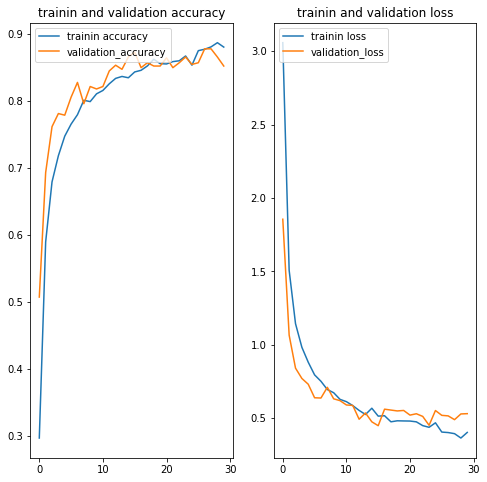

In [13]:
accuracy=history.history["accuracy"]
val_accuracy=history.history["val_accuracy"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]

epoch_range=range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epoch_range, accuracy, label="trainin accuracy")
plt.plot(epoch_range, val_accuracy, label="validation_accuracy")
plt.legend(loc="upper left")
plt.title("trainin and validation accuracy")

plt.subplot(1,2,2)
plt.plot(epoch_range, loss, label="trainin loss")
plt.plot(epoch_range, val_loss, label="validation_loss")
plt.legend(loc="upper left")
plt.title("trainin and validation loss")


In [14]:
# generate test image and applying image augmentation

test_gen=ImageDataGenerator(rescale=1./255)
test_data_gen=test_gen.flow_from_directory(test_dir, batch_size=32, target_size=(image_shape, image_shape),
                                          class_mode="sparse")

Found 819 images belonging to 102 classes.


In [0]:
import time

# save model to use in future for predictions (in keras format)
#timestamp is used for file name

t=time.time()
export_file_path="./{}.h5".format(int(t))
model.save(export_file_path)

In [16]:
#Now reload model and apply different operations

reloaded_model=tf.keras.models.load_model(export_file_path, 
                                          custom_objects={"KerasLayer":hub.KerasLayer})
reloaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 102)               52326     
Total params: 24,478,086
Trainable params: 2,675,302
Non-trainable params: 21,802,784
_________________________________________________________________


In [17]:
print("Loss and accuracy on test data: ",model.evaluate_generator(test_data_gen, steps=int(np.ceil(819/batch_size))))
print("Loss and accuracy on test data using keras's saved model: ",reloaded_model.evaluate_generator(test_data_gen, steps=int(np.ceil(819/batch_size))))

Loss and accuracy on test data:  [0.5088476421168218, 0.8656899]
Loss and accuracy on test data using keras's saved model:  [0.5174709910956713, 0.8656899]


In [18]:
#save model in tensorflow format

t=time.time()
export_path_sm="./{}".format(int(t))
tf.saved_model.save(model, export_path_sm)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: ./1575751853/assets


INFO:tensorflow:Assets written to: ./1575751853/assets


In [0]:
reloaded_model_sm=tf.saved_model.load(export_path_sm)

Since tf's saved model don't have fit, evaluate and predict methods, so to perform these operations we have to load saved model as keras model. Because keras model has all these methods. 

In [20]:
#loading tf saved_model as keras model

reloaded_model_as_keras=tf.keras.models.load_model(export_path_sm,
                                                   custom_objects={"KerasLayer":hub.KerasLayer})
reloaded_model_as_keras.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 102)               52326     
Total params: 24,478,086
Trainable params: 2,675,302
Non-trainable params: 21,802,784
_________________________________________________________________


In [21]:
#evaluating on test data using reloaded model

reloaded_model_as_keras.evaluate_generator(test_data_gen, steps=int(np.ceil(819/batch_size)))

[0.514575940485184, 0.8656899]

In [0]:
#upload 'category_to_label.json' file which contains image lables

uploaded=files.upload()

In [23]:
import json
with open("category_to_label.json") as labels:
  label_data=json.load(labels)
print(label_data)

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

In [0]:
lst=[]
for i in range(1, 103):
  for j in label_data:
    if str(i)==j:
      lst.append(label_data[j])
      break

In [0]:
lst=np.array(lst)

In [26]:
#predicting class labels

image_batch, label_batch = next(iter(test_data_gen))

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names=lst[predicted_ids]
print(predicted_class_names)

['oxeye daisy' 'hippeastrum' 'cautleya spicata' "colt's foot"
 'desert-rose' 'clematis' 'wild pansy' 'sunflower' 'alpine sea holly'
 'gaura' 'geranium' 'mexican petunia' 'barbeton daisy' 'spear thistle'
 'mallow' 'great masterwort' 'azalea' 'great masterwort' 'clematis'
 'frangipani' 'mexican petunia' 'rose' 'gaura' 'petunia'
 'cautleya spicata' 'spring crocus' 'mexican petunia' 'mexican aster'
 'poinsettia' 'tree poppy' 'orange dahlia' 'windflower']


In [27]:
#comparing predictions

print("predicted values: ", predicted_ids)
print("label values:     ", label_batch.astype(int))

predicted values:  [48 90 60 11 84 81 51 53 34 56 57 97 40 13 96 37 71 37 81 80 97 73 56 50
 60 66 97 33 43 69 58 68]
label values:      [48 98 60 11 84 81 51 53 34 56 57 97 92 83 96 99 71 37 36 80 97 73 56 50
 60 66 97 33 43 69 58 68]


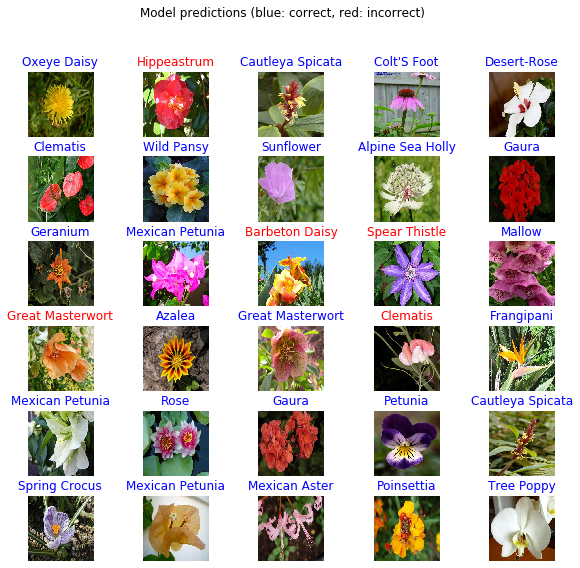

In [28]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

In [0]:
uploaded = files.upload()

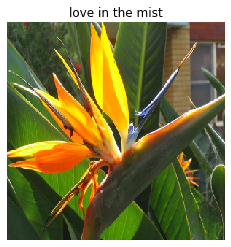

In [31]:
from keras.preprocessing import image

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(image_shape, image_shape))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  #images = np.vstack([x])
  classes = reloaded_model.predict(x)
  prediction = tf.squeeze(classes).numpy()
  predicted_id = np.argmax(prediction)
  predicted_class_name=lst[predicted_id]
  plt.title(predicted_class_name)
  plt.imshow(img)
  plt.axis("off")